# Mixology
v0.1

## Environment Setup

In [2]:
%load_ext autoreload
%autoreload 2

import os
import typedb
import pickle
import operator
import copy

import networkx as nx
import networkx.algorithms.isomorphism as iso
import pandas as pd
import azlib.queries as azq
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

from collections import Counter
from collections import defaultdict
from tqdm import tqdm
from typedb.client import *
from typing import List, Dict
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from azlib.utils import get_id_name_map
from azlib.utils import sort_graph_nodes
from azlib.utils import rebuild_pkls
from kglib.utils.graph.query.query_graph import QueryGraphAZ
from kglib.utils.graph.thing.queries_to_networkx_graph import build_graph_from_queries

DATABASE = "orbit"
ADDRESS = "localhost:1729"

client = TypeDB.core_client(ADDRESS)
session = client.session(DATABASE, SessionType.DATA)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Loading

In [312]:
# rebuild the following pkl files:
#   - compound_ingredients.pkl
#   - non_compound_ingredients.pkl
#   - npmi_pair_scores.pkl
pwd = os.path.dirname(os.path.realpath("__file__"))
rebuild_pkls(pwd=pwd)

Writing compound_ingredients.pkl...
Writing non_compound_ingredients.pkl...
Writing npmi_pair_scores.pkl...


In [3]:
# load id_to_name mapping
print('Loading id_to_name mapping...')
map_c_id_to_name, map_n_id_to_name, map_f_id_to_name = get_id_name_map(session, 'id_to_name', True, 0)
map_id_to_name = defaultdict(lambda: None)
map_id_to_name.update(map_c_id_to_name)
map_id_to_name.update(map_n_id_to_name)
map_id_to_name.update(map_f_id_to_name)

# load name_to_id mapping
print('')
print('Loading name_to_id mapping...')
map_c_name_to_id, map_n_name_to_id, map_f_name_to_id = get_id_name_map(session, 'name_to_id', True, 0)
map_name_to_id = defaultdict(lambda: None)
map_name_to_id.update(map_c_name_to_id)
map_name_to_id.update(map_n_name_to_id)
map_name_to_id.update(map_f_name_to_id)

# load training set
print('')
print('Loading training dataset...')
pwd = os.path.dirname(os.path.realpath("__file__"))
with open(f"{pwd}/data/graphs_tc.pkl", "rb") as f:
    graphs = pickle.load(f)
print('Completed!')

Loading id_to_name mapping...
Compound-Ingredient Total Count: 46
Non-Ingredient Total Count: 285
Flavor-Compound Total Count: 1118

Duplicate Compound-Ingredient Count: 1072
Duplicate Non-Ingredient Count: 0
Duplicate Flavor-Compound Count: 0

Loading name_to_id mapping...
Compound-Ingredient Total Count: 46
Non-Ingredient Total Count: 285
Flavor-Compound Total Count: 1118

Duplicate Compound-Ingredient Count: 0
Duplicate Non-Ingredient Count: 0
Duplicate Flavor-Compound Count: 0

Loading training dataset...
Completed!


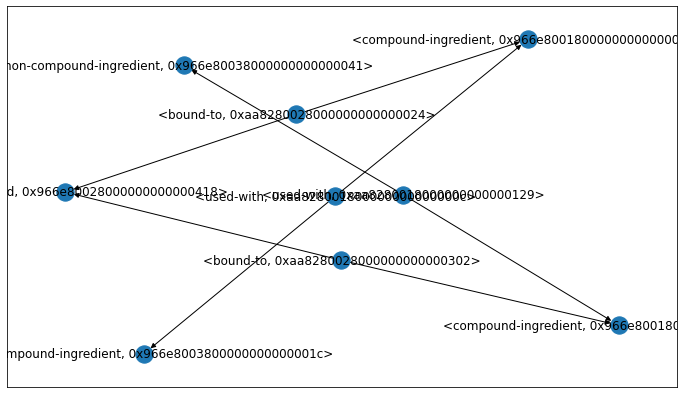

In [4]:
g = copy.deepcopy(graphs[0])
plt.figure(figsize=(12,7)) 
nx.draw_networkx(g, with_labels=True)

In [5]:
VERBOSE = False

# extract nodes in order from nextworkx meta-path instances
nodes_paths = []
for i, graph in tqdm(enumerate(graphs), total=len(graphs)):
    # str(graph) gives the name of the first node in the graph
    seed_node_id = map_name_to_id[str(graph)]
    if not seed_node_id:
        print(f'Warning: Missing mapping for "{str(graph)}", index = {i}...')
    else:
        if VERBOSE:
            print(f'Extracting {graph}...')
        nodes_paths.append(sort_graph_nodes(graph, seed_node_id, map_id_to_name))

print(f'Total number of paths extracted: {len(nodes_paths)}')

100%|██████████| 78496/78496 [01:52<00:00, 697.26it/s]

Total number of paths extracted: 78496


## EDA

In [6]:
# extract ingredient counts
node_counter = Counter([node for path in nodes_paths for node in path])
ingredients_dict = {}
for key, val in node_counter.items():
    if key not in map_f_name_to_id.keys():
        ingredients_dict[key] = val
sorted_ingredients_dict = {k: v for k, v in sorted(ingredients_dict.items(), key=lambda item: item[1])}

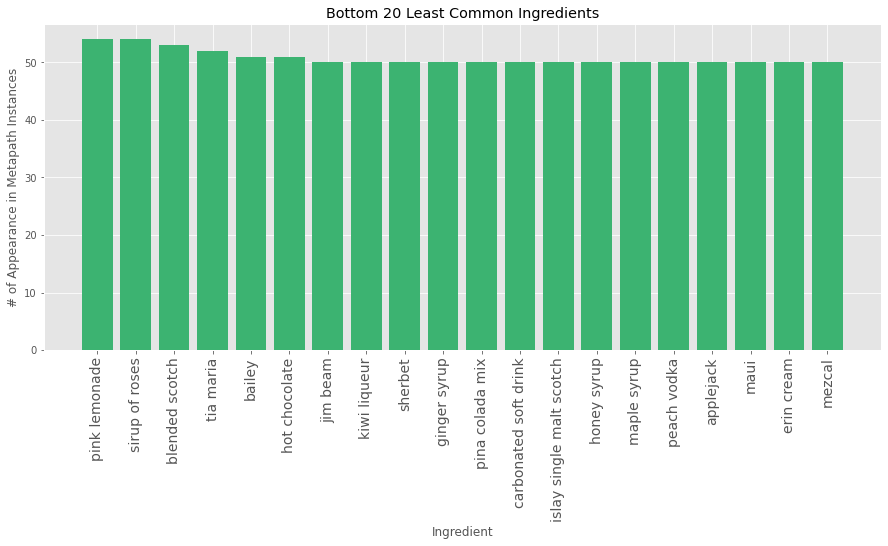

In [7]:
RANKS = 20
x_axis = list(sorted_ingredients_dict.keys())[:RANKS]
y_axis = list(sorted_ingredients_dict.values())[:RANKS]
x_pos = [i for i, _ in enumerate(x_axis)]

plt.style.use('ggplot')
plt.figure(figsize=(15, 6))
plt.bar(x_axis[::-1], y_axis[::-1], color='mediumseagreen')
plt.xlabel("Ingredient")
plt.ylabel("# of Appearance in Metapath Instances")
plt.title(f"Bottom {RANKS} Least Common Ingredients")
plt.xticks(x_pos, x_axis, fontsize=14, rotation=90)

plt.show()
pass

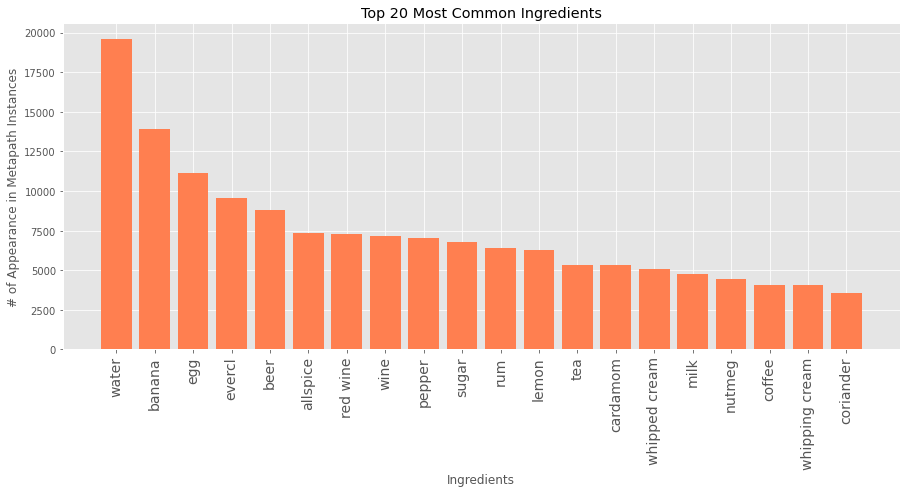

In [8]:
RANKS = 20
x_axis = list(sorted_ingredients_dict.keys())[-RANKS:]
y_axis = list(sorted_ingredients_dict.values())[-RANKS:]
x_pos = [i for i, _ in enumerate(x_axis)]

plt.style.use('ggplot')
plt.figure(figsize=(15, 6))
plt.bar(x_axis[::-1], y_axis[::-1], color='coral')
plt.xlabel("Ingredients")
plt.ylabel("# of Appearance in Metapath Instances")
plt.title(f"Top {RANKS} Most Common Ingredients")
plt.xticks(x_pos, x_axis, fontsize=14, rotation=90)

plt.show()
pass

## Training

In [16]:
SAVE_MOEL = False

# train the skip-gram
print('Training Word2Vec...')
model = Word2Vec(
            sentences=nodes_paths, 
            epochs=10, 
            vector_size=100, 
            window=5, 
            min_count=0, 
            sg=1, 
            workers=2)
if SAVE_MOEL:
    pwd = os.path.dirname(os.path.realpath('__file__'))
    save_path = f'{pwd}/models/word2vec.wordvectors' 
    model.save(save_path)
    print(f'Model saved to {save_path}...')

# retrieve node embeddings and corresponding subjects
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (
    model.wv.vectors
)

# build vectors for compound ingredients
print('Building vectors for compound ingredients...')
ingredient_vectors, ingredient_names = [], []
for node_name in map_c_id_to_name.values():
    ingredient_vectors.append(model.wv[node_name])
    ingredient_names.append(node_name)
node_count_compound_ingred = len(ingredient_vectors)
print(f'# of Compound Ingredients: {node_count_compound_ingred}')

# build vectors for non-compound ingredients
# NOTE: Some non-compound ingredients are not found because only ingredients with 
#       NPMI >= 0.25 have the relations established in the db.
print('Building vectors for non-compound ingredients...')
for node_name in map_n_id_to_name.values():
    try:
        ingredient_vectors.append(model.wv[node_name])
        ingredient_names.append(node_name)
    except:
        print(f'\tNon-compound Ingrendient Not Found: {node_name}')
print(f'# of Non-compound Ingredients: {len(ingredient_vectors) - node_count_compound_ingred}')
print('Completed!')

Training Word2Vec...
Building vectors for compound ingredients...
# of Compound Ingredients: 46
Building vectors for non-compound ingredients...
	Non-compound Ingrendient Not Found: firewater
	Non-compound Ingrendient Not Found: corona
	Non-compound Ingrendient Not Found: ale
	Non-compound Ingrendient Not Found: absolut peppar
	Non-compound Ingrendient Not Found: sarsaparilla
	Non-compound Ingrendient Not Found: zima
	Non-compound Ingrendient Not Found: black sambuca
	Non-compound Ingrendient Not Found: iced tea
# of Non-compound Ingredients: 277
Completed!


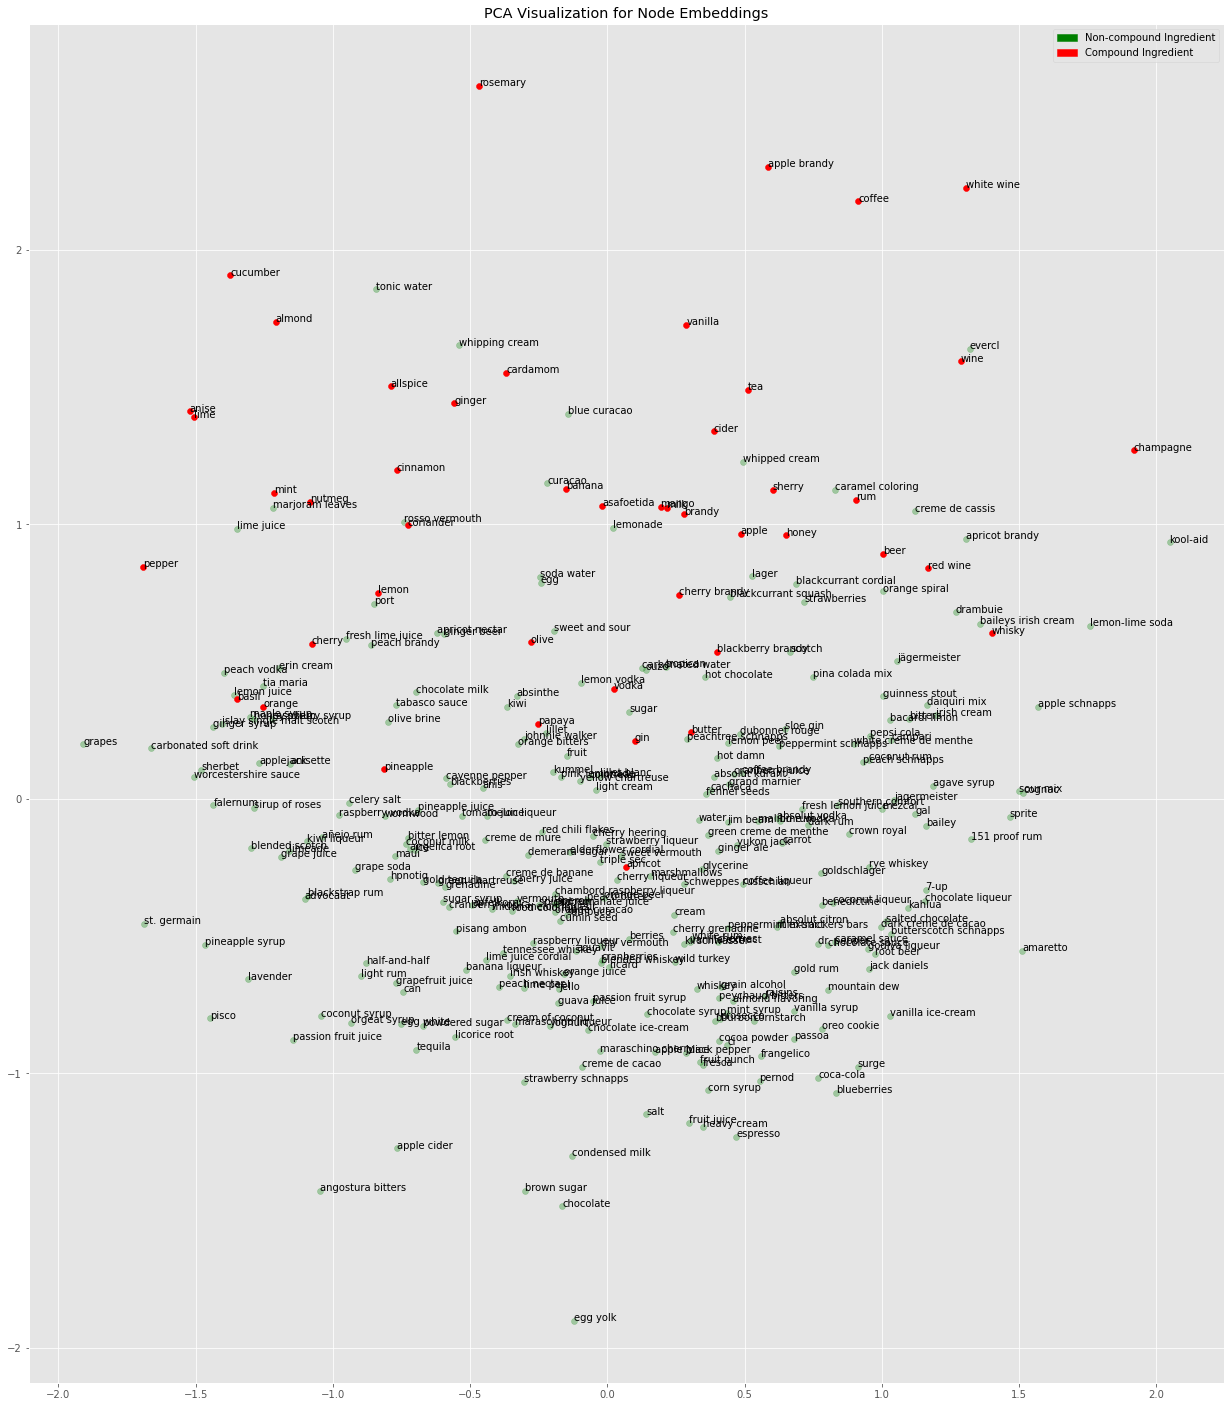

In [24]:
# dim reduction for plotting
transform = PCA  # PCA or TSNE
trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(ingredient_vectors)

# plot the learned node embeddings
plt.figure(figsize=(25, 25))
plt.axes().set(aspect="equal")

# plot non-compound ingredients
plt.scatter(node_embeddings_2d[node_count_compound_ingred:, 0], node_embeddings_2d[node_count_compound_ingred:, 1], color='green', alpha=0.3)
# plot compound ingredients
plt.scatter(node_embeddings_2d[:node_count_compound_ingred, 0], node_embeddings_2d[:node_count_compound_ingred, 1], color='red', alpha=1)

# add text
for i, txt in enumerate(ingredient_names):
    plt.annotate(txt, (node_embeddings_2d[:, 0][i], node_embeddings_2d[:, 1][i]))

# add ledgend & title
plt.legend(handles=[
    mpatches.Patch(color='green', label='Non-compound Ingredient'),
    mpatches.Patch(color='red', label='Compound Ingredient')
])
plt.title(f"{transform.__name__} Visualization for Node Embeddings")
plt.show()
pass

## Distance Analysis

### Pairing by Cosine Distance

In [27]:
# cosine distance function between 2 vectors, a and b
def compare(a_vector, b_vector):

    ma = np.linalg.norm(a_vector)
    mb = np.linalg.norm(b_vector)
    score = (np.matmul(a_vector,b_vector)) / (ma * mb)

    return score

# recommend ingredient pairs
def find_pairings(
            names, 
            ingredient_names = ingredient_names, 
            top_n_pairings: int = 5):
    paired_ingredients, scores = [], []
    summed_vector = np.zeros(100)
    for name in names:
        vector = model.wv[name]
        summed_vector += vector
        
    ingredient_vector_dict = {}
    for name in ingredient_names:
        ingredient_vector_dict[name] = model.wv[name]
   
    scoring_dict = {}
    for key, val in zip(ingredient_vector_dict.keys(), ingredient_vector_dict.values()):
        score = compare(summed_vector, val)
        scoring_dict[key] = score
    sorted_scoring_dict = dict(sorted(scoring_dict.items(), key=operator.itemgetter(1),reverse=True))
    
    for idx, (key, val) in enumerate(zip(sorted_scoring_dict.keys(), sorted_scoring_dict.values())):
        if idx <= top_n_pairings + 1 and key not in names:
            paired_ingredients.append(key)
            scores.append(val)
   
    return paired_ingredients, scores

In [28]:
INGREDIENTS = ["ice", "rum"]
# INGREDIENTS = ["egg"]

pairings, scores = find_pairings(INGREDIENTS, top_n_pairings=10)
results_df = pd.DataFrame({'Ingredient': pairings, 'Cosine Distance': scores})
print(f'Ingredient(s): {INGREDIENTS}')
print(results_df)

Ingredient(s): ['ice', 'rum']
          Ingredient  Cosine Distance
0        fruit punch         0.546740
1         grape soda         0.537250
2        cranberries         0.537161
3               maui         0.537055
4       pisang ambon         0.526898
5       blackberries         0.522809
6           prosecco         0.521348
7  pomegranate juice         0.521289
8           vermouth         0.521256
9         cornstarch         0.520236


### Pairing by NPMI

In [29]:
def get_npmi_pairs() -> tuple:
    """Get ingredient-NPMI pairs.
    Return:
        npmi_pair_scores (list): List of score pair tuples. E.g. (('coca-cola', 'beer'), 0.37072622585250825)
        npmi_pair_scores_dict (dict): Dict of score pairs. Key is the ingredient-pair sorted 
                                      in alphabetical order, converted to string by joining with '-'.
                                      e.g. {'beer-coca-cola': 0.37072622585250825,
                                            'coca-cola-tennessee whiskey': 0.6234571625127486}
    """
    pwd = os.path.dirname(os.path.realpath("__file__"))
    with open(f'{pwd}/data/npmi_pair_scores.pkl', "rb") as f:
        npmi_pair_scores = pickle.load(f)

    npmi_pair_scores_dict = defaultdict(lambda: None)
    for pair in npmi_pair_scores:
        # key is ingredient pair sorted alphabetically
        key = list(pair[0])
        key.sort()
        key_str = '-'.join(key)

        npmi_pair_scores_dict[key_str] = pair[1]
    
    return npmi_pair_scores, npmi_pair_scores_dict


def recipe_based_pairings(name, top_n_pairings, npmi_pair_scores) -> tuple:
    """Function to recommend pairing simply using NMPI scores.
    """
    paired_ingredients = []
    for pairing, score in npmi_pair_scores:
        if pairing[0] == name:
            paired_ingredients.append((pairing[1], score))
        elif pairing[1] == name:
            paired_ingredients.append((pairing[0], score))
    
    # sort list of tuple based on the scores
    paired_ingredients.sort(key=lambda x:x[1])
    
    # return top_n results
    top_n = {}
    for idx in range(top_n_pairings):
        ingredient = paired_ingredients[-1-idx]
        top_n[ingredient[0]] = ingredient[1]
        
    return top_n, paired_ingredients

In [30]:
INGREDIENT = "milk"

# load the npmi scores for all ingredient-ingredient pairs from the migrators
npmi_pair_scores, _ = get_npmi_pairs()
top_n_pairings, paired_ingredients = recipe_based_pairings(INGREDIENT, 10, npmi_pair_scores)

# print top_n results
results_df = pd.DataFrame({'Ingredient': top_n_pairings.keys(), 'NPMI Score': top_n_pairings.values()})
print(f'Ingredient: {INGREDIENT}')
print(results_df)

Ingredient: milk
              Ingredient  NPMI Score
0              chocolate    0.558866
1         godiva liqueur    0.539290
2  butterscotch schnapps    0.484697
3        vanilla extract    0.451522
4             mint syrup    0.446254
5           black pepper    0.446254
6          caramel sauce    0.446254
7             cornstarch    0.446254
8     mini-snickers bars    0.446254
9           cocoa powder    0.442351


### Pairing Cosine Distance vs. NPMI

In [37]:
def load_npmi_scores(ingredient: str, paired_ingredients: List[str]) -> List[float]:
    """Load NPMI scores for the ingredient pair, if found from the dict instances 
    returned by get_npmi_pairs().
    Args: 
        ingredient (str): Main ingredient to be paired. 
        paired_ingredients (List[str]): Ingredients that are paired to the main ingredient.
    Return:
        (List[float]): A list of NPMI scores in the order of paired_ingredients. Note that
                       the scores can be missing for ingredients if the two ingredients do 
                       co-occur in the same recipe or do not co-occur frequently enough to 
                       have an NPMI >= 0.25 in the graph DB. 
    """
    _, npmi_pair_scores_dict = get_npmi_pairs()

    scores = {}
    for paired_igred in paired_ingredients:
        # build key
        pair = [ingredient, paired_igred]
        pair.sort()
        key_str = '-'.join(pair)
        
        # insert to hash table
        scores[paired_igred] = npmi_pair_scores_dict[key_str]

    return scores

In [38]:
INGREDIENT = "milk"

# load cosine
paired_ingredients, cos_scores = find_pairings([INGREDIENT], top_n_pairings=10)

# load npmi
paired_ingredients_npmi_dict = load_npmi_scores(INGREDIENT, paired_ingredients)

# print report
results_df = pd.DataFrame({
                'Ingredient': paired_ingredients, 
                'Cosine Distance': cos_scores, 
                'NPMI Score': paired_ingredients_npmi_dict.values()
            })
print(f'Ingredient(s): {INGREDIENT}')
print(results_df)

Ingredient(s): milk
               Ingredient  Cosine Distance  NPMI Score
0      mini-snickers bars         0.493101    0.446254
1                  mezcal         0.455205         NaN
2            goldschlager         0.423921         NaN
3            jagermeister         0.415851         NaN
4           caramel sauce         0.405204    0.446254
5         chocolate sauce         0.392293    0.337408
6          godiva liqueur         0.390539    0.539290
7   butterscotch schnapps         0.384981    0.484697
8            marshmallows         0.376831         NaN
9       chocolate liqueur         0.376480    0.273738
10         coffee liqueur         0.368816         NaN
